In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime

# calling functions from the util.py file
from util import (
    countplot_viz,
    distplot_viz,
    countplot_pointplot_viz,
    countplot_pointplot_viz_top15,
    df_descriptive_statistics,
)

from datetime import datetime
from datetime import timedelta


# ignoring warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None

# adding useful magic functions
%load_ext lab_black
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# Uploading data set
df_data = pd.read_csv("mondu_fraud_case_study.csv")

In [3]:
df_data.head()

,account_age_days,transaction_amt,transaction_adj_amt,historic_velocity,ip_address,user_agent,email_domain,phone_number,billing_city,billing_postal,billing_state,card_bin,currency,cvv,signature_image,transaction_type,transaction_env,EVENT_TIMESTAMP,applicant_name,billing_address,merchant_id,locale,tranaction_initiate,days_since_last_logon,inital_amount,EVENT_LABEL
0,3371.0,2167.0,56.0,2572.0,154.68.49.124,Opera/9.81.(Windows NT 10.0; ht-HT) Presto/2.9...,perez-garza.com,878-111-5140,Woodsburgh,96336.0,California,40771.0,cad,D,F,U,X,29.12.20 09:05,Linda Wright,4684 Sharon Ranch,066-82-8795,niu_NZ,O,59.0,13646.0,legit
1,2714.0,2045.0,48.0,4517.0,39.131.125.85,Opera/9.76.(X11; Linux i686; mi-NZ) Presto/2.9...,mcneil-ortega.com,(002)736-0139,West Kevin,78083.0,Florida,24480.0,cad,X,X,H,W,22.06.21 18:05,Terri Rivera,7642 Allison Ramp,669-99-9459,apn_IN,J,0.0,11930.0,legit
2,6987.0,2892.0,61.0,5007.0,166.245.194.83,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,davis-calderon.com,(983)585-2863x652,Lorichester,83236.0,Utah,37778.0,cad,X,Q,X,X,10.05.21 13:48,Sarah Gray,4948 Lisa Passage,086-41-1624,dv_MV,T,83.0,7412.0,legit
3,2712.0,3040.0,28.0,6022.0,100.1.217.216,Mozilla/5.0 (Macintosh; Intel Mac OS X 10 9_3 ...,rose-lee.org,+1-678-897-3420x60738,Stephenmouth,78364.0,Virginia,55790.0,usd,G,G,C,N,11.03.21 07:36,Valerie Jenkins,1616 Little Camp,669-97-4021,byn_ER,M,24.0,4623.0,legit
4,3598.0,2976.0,66.0,2600.0,113.156.65.245,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.5.20) G...,nash.net,(013)204-1766x92641,New Brianmouth,77499.0,South Carolina,37370.0,cad,X,F,F,G,27.03.21 06:13,Amy Coleman,149 Harris Rapid,088-21-6329,the_NP,K,21.0,1905.0,legit


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   account_age_days       149892 non-null  float64
 1   transaction_amt        149870 non-null  float64
 2   transaction_adj_amt    149886 non-null  float64
 3   historic_velocity      149885 non-null  float64
 4   ip_address             149873 non-null  object 
 5   user_agent             149887 non-null  object 
 6   email_domain           149910 non-null  object 
 7   phone_number           149873 non-null  object 
 8   billing_city           149884 non-null  object 
 9   billing_postal         149876 non-null  float64
 10  billing_state          149887 non-null  object 
 11  card_bin               149872 non-null  float64
 12  currency               149892 non-null  object 
 13  cvv                    149877 non-null  object 
 14  signature_image        149895 non-nu

In [5]:
# Adding new column for using in the rate calculations:

df_data["EVENT_LABEL_"] = np.where(df_data["EVENT_LABEL"] == "fraud", 1, 0)

## Understanding Variables:
### Target Varible: Event Label

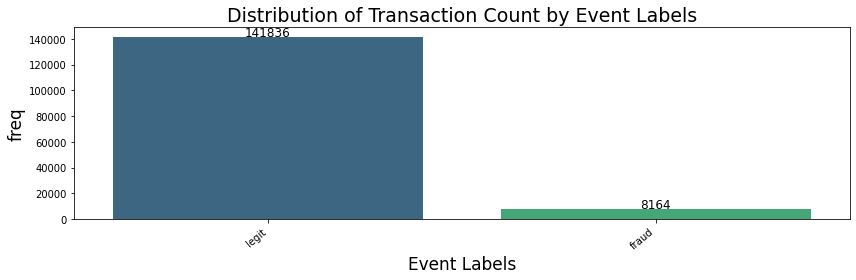

In [6]:
# Distribution of transaction counts by whether fraud or not:

countplot_viz(
    df_data,
    "EVENT_LABEL",
    "Event Labels",
    "freq",
    "Distribution of Transaction Count by Event Labels",
    figsize_x=12,
    figsize_y=4,
    palette="viridis",
)

In [7]:
# EVENT_LABEL column ratio
df_data.groupby(by=["EVENT_LABEL"])["transaction_amt"].count() / df_data[
    "transaction_amt"
].count()

EVENT_LABEL
fraud    0.05442
legit    0.94558
Name: transaction_amt, dtype: float64

* There are 2 different categories as the event labels: Fraud and Legit
* Rate of the fraudelent activities in total activities is 0.0544 

### Bivariate Relationships: Time Variables
### Event Timestamp & Event Label

In [8]:
# Changing type of EVENT_TIMESTAMP column from object to datetime:

df_data["EVENT_TIMESTAMP"] = pd.to_datetime(df_data["EVENT_TIMESTAMP"])

In [9]:
# Adding new columns as year, month, weekday, hour and day.

df_data["Weekday"] = df_data[
    "EVENT_TIMESTAMP"
].dt.dayofweek  # To see Weekdays of the week
df_data["Hour"] = df_data["EVENT_TIMESTAMP"].dt.hour  # To see hours of the day
df_data["Day"] = df_data["EVENT_TIMESTAMP"].dt.day  # To see days of the month
df_data["Year"] = df_data["EVENT_TIMESTAMP"].dt.year  # To see years of the column
df_data["Month"] = df_data["EVENT_TIMESTAMP"].dt.month  # To see months of the column

### Yearly check:

In [10]:
# To see which years we have in the dataset:

df_data["Year"].unique()

array([2020., 2021.,   nan])

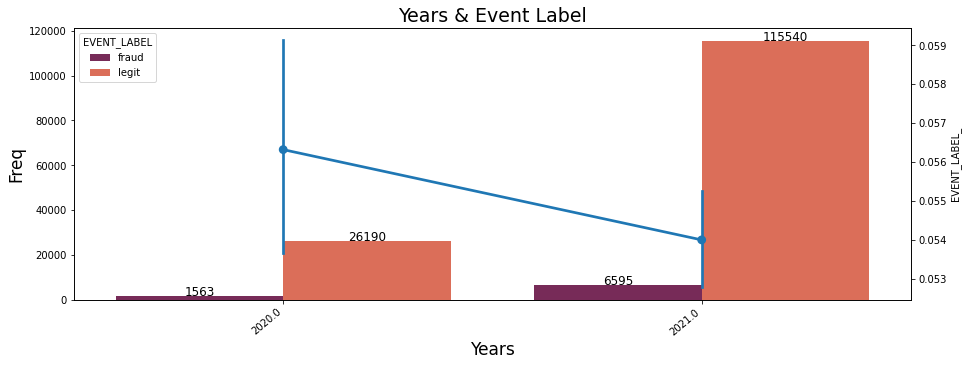

In [11]:
# To see count of fraud and legit transaction for each value in Year column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Year",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Years",
    "Freq",
    "Years & Event Label",
    palette="rocket",
    figsize_x=15,
    figsize_y=5,
)

#### Findings: 
* 2021 is the highest fraudelent activity year 
* 2020 is the highest fraudelent activity ratio year 

### Monthly check:

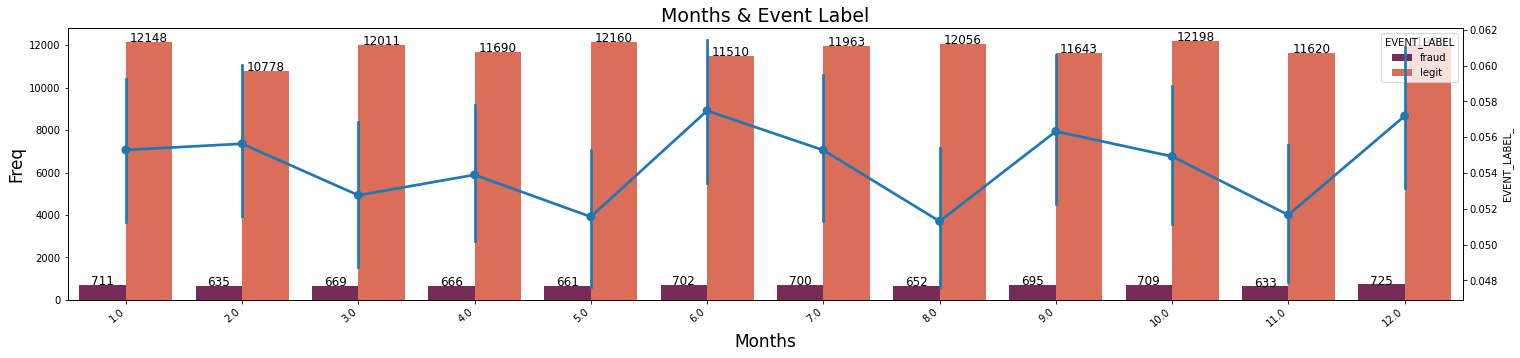

In [12]:
# To see count of fraud and legit transaction for each value in Month column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Month",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Months",
    "Freq",
    "Months & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
 * Highest fraudelent activities are in December, June and September

### Day of the Week Check:

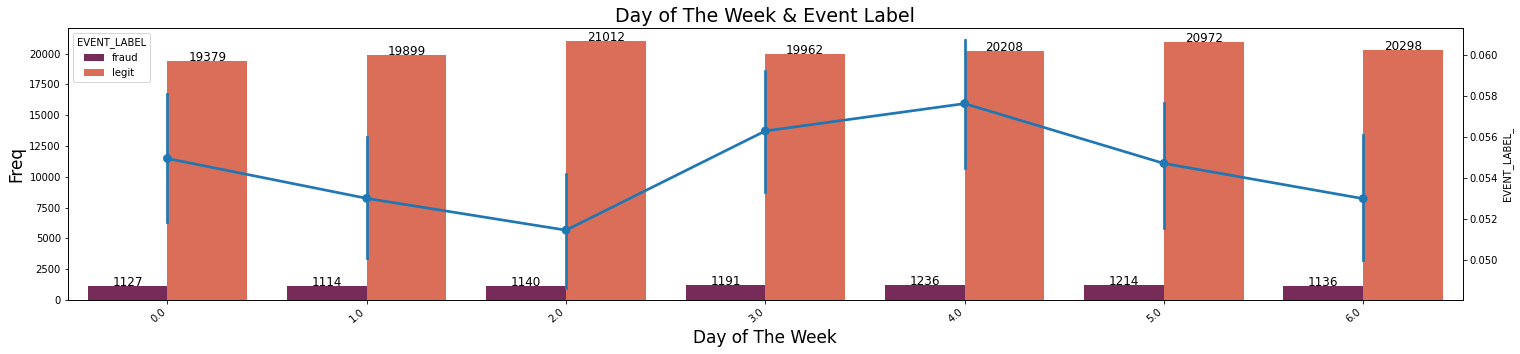

In [13]:
# The day of the week starts with Monday=0 and ends with Sunday=6. To see count of fraud and legit transaction for each value in Day of Week column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Weekday",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Day of The Week",
    "Freq",
    "Day of The Week & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

#### Findings:
* Friday has the highest fraudelent activitie count and ratio. 

### Day of Month Check: 

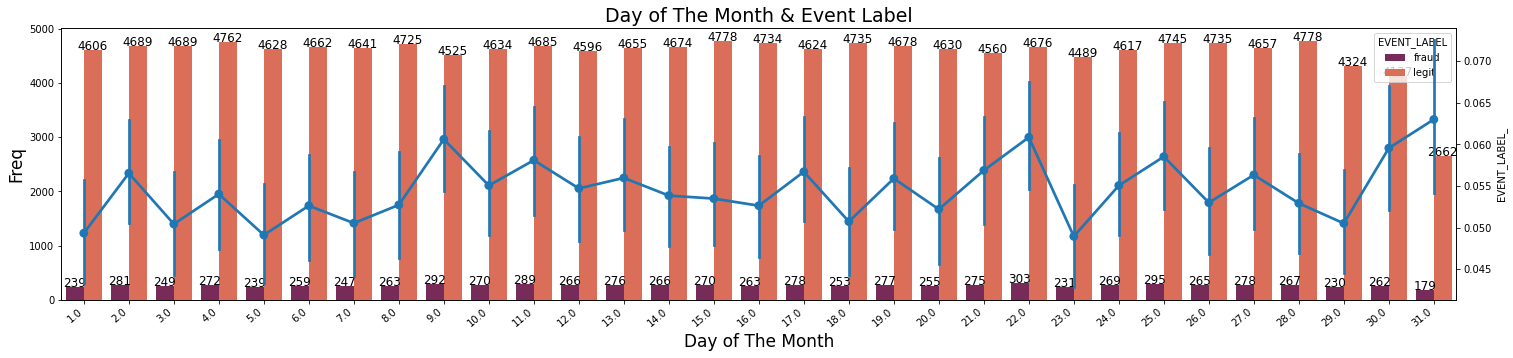

In [14]:
# The day of the months starts with 1 and ends with 31. To see count of fraud and legit transaction for each value in Day of Month column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Day",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Day of The Month",
    "Freq",
    "Day of The Month & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* On 31th, 22th and 9th we observe the higestes fraudelent activity ratio.  

### Hour of Day Check: 

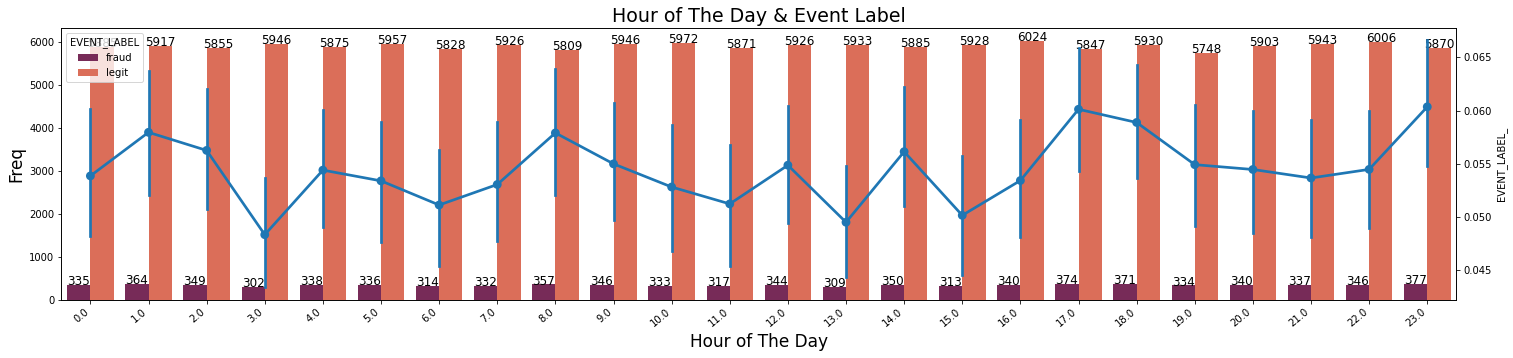

In [15]:
# The hours of day with 24=0.0, 1=1.0, etc. To see count of fraud and legit transaction for each value in Hour of the Day column:

filter_list = ["fraud", "legit"]
countplot_pointplot_viz(
    df_data,
    filter_list,
    "Hour",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Hour of The Day",
    "Freq",
    "Hour of The Day & Event Label",
    palette="rocket",
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* At 23, 17 and 18 we observe the highest fraudelent activity ratio. 
    * It shows that at late and after work hours fraudelent activities occur more. 

### Bivariate Relationships: Numerics Variables
### Transaction Amount & Event Label:
#### Assumption: 

Transactions are happening in different currencies. When I compare Euro to Canada and America Dollars, I see that maximum ratio is 1.8 in the last 2 years. Which means I will not apply a currency scaling in here. But in a real project we need to convert them to the same scale for appropriate comparison.

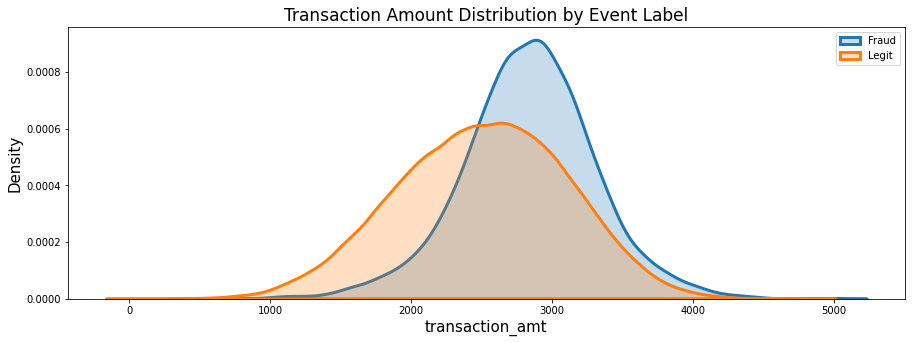

In [16]:
# To see transaction amount distribution for EVENT_LABEL column:
distplot_viz(
    data=df_data,
    column="transaction_amt",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Transaction Amount Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [17]:
list_of_column_descriptive = ["transaction_amt"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       transaction_amt
count      8156.000000
mean       2833.471187
std         474.385893
min         814.000000
25%        2545.000000
50%        2841.000000
75%        3130.000000
max        4999.000000

Mode: 
    transaction_amt
0           2836.0

Legit transactions; 

       transaction_amt
count    141714.000000
mean       2503.501849
std         606.305683
min           5.000000
25%        2081.000000
50%        2519.000000
75%        2935.000000
max        4844.000000

Mode: 
    transaction_amt
0           2275.0



#### Findings: 
* Fraudelent transactions have smaller variance compared to legit transactions.  
* Fraudelent transaction's minimum value is 175 times bigger than legit transactions.
* These information shows that fraudelent people only focuses on certain amount of transactions. Small numbers are not important for them.

### Account Age & Event Label:

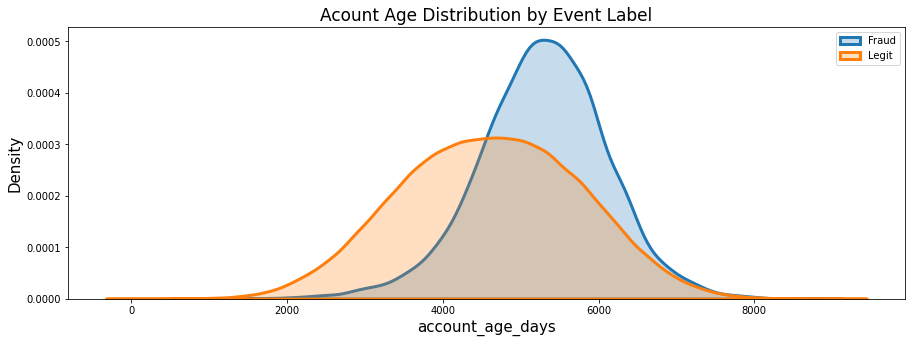

In [18]:
# To see transaction amount distribution for Account Age column:
distplot_viz(
    data=df_data,
    column="account_age_days",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Acount Age Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [19]:
list_of_column_descriptive = ["account_age_days"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       account_age_days
count       8158.000000
mean        5275.526354
std          831.440621
min          931.000000
25%         4762.250000
50%         5298.000000
75%         5819.000000
max         8722.000000

Mode: 
    account_age_days
0            5105.0
1            5168.0

Legit transactions; 

       account_age_days
count     141734.000000
mean        4609.503111
std         1159.306448
min            1.000000
25%         3780.000000
50%         4615.000000
75%         5439.750000
max         9119.000000

Mode: 
    account_age_days
0            4616.0



#### Findings: 
* Fraudelent transactions have smaller variance compared to legit transactions.  
* Fraudelent transaction's minimum value is 931 times bigger than legit transactions.
* These information shows that fraudelent people only focuses on accounts are older than 3.5 years. Newly created accounts are not in their target group.

### Days Since Last Logon & Event Label:

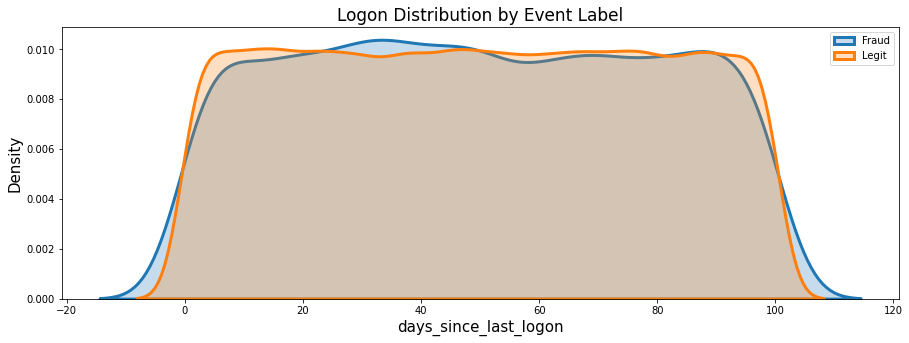

In [20]:
# To see transaction amount distribution for Account Days Since Last Logon column:
distplot_viz(
    data=df_data,
    column="days_since_last_logon",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Logon Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [21]:
list_of_column_descriptive = ["days_since_last_logon"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       days_since_last_logon
count            8155.000000
mean               49.808584
std                29.181661
min                 0.000000
25%                25.000000
50%                49.000000
75%                75.000000
max               100.000000

Mode: 
    days_since_last_logon
0                   51.0

Legit transactions; 

       days_since_last_logon
count          141709.000000
mean               49.869719
std                29.206195
min                 0.000000
25%                24.000000
50%                50.000000
75%                75.000000
max               100.000000

Mode: 
    days_since_last_logon
0                   36.0



#### Findings: 
* Fraudelent and legit distributions are approximately similar.  

### Inital Amount & Event Label:  

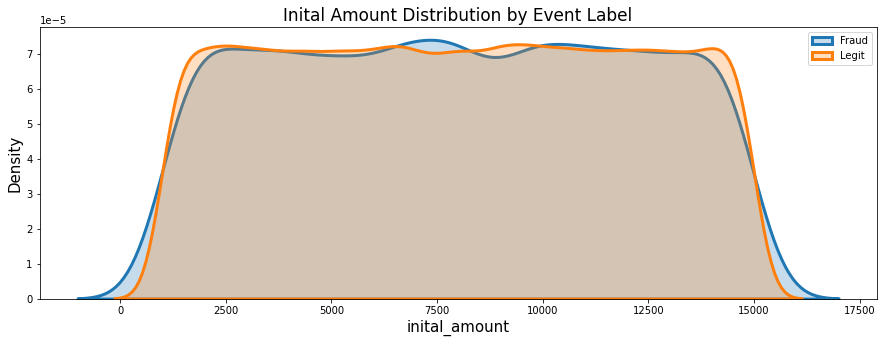

In [22]:
# To see transaction amount distribution for Initial Amount column:
distplot_viz(
    data=df_data,
    column="inital_amount",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Inital Amount Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [23]:
list_of_column_descriptive = ["inital_amount"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       inital_amount
count    8154.000000
mean     7990.473019
std      4046.830103
min      1001.000000
25%      4464.750000
50%      7941.500000
75%     11471.750000
max     14999.000000

Mode: 
    inital_amount
0         5239.0

Legit transactions; 

       inital_amount
count  141718.000000
mean     7998.459808
std      4047.099300
min      1000.000000
25%      4488.000000
50%      8006.000000
75%     11495.750000
max     15000.000000

Mode: 
    inital_amount
0         7249.0



#### Findings: 
* Fraudelent and legit distributions are approximately similar. 

### Adjusted Transaction Amount & Event Label:  

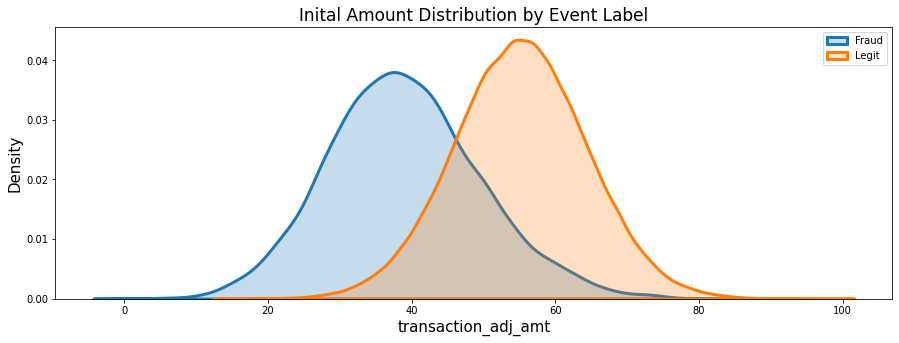

In [24]:
# To see transaction amount distribution for Adjusted Transaction Amount column:
distplot_viz(
    data=df_data,
    column="transaction_adj_amt",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Inital Amount Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [25]:
list_of_column_descriptive = ["transaction_adj_amt"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       transaction_adj_amt
count          8154.000000
mean             38.921511
std              10.656034
min               1.000000
25%              32.000000
50%              38.000000
75%              46.000000
max              78.000000

Mode: 
    transaction_adj_amt
0                 38.0

Legit transactions; 

       transaction_adj_amt
count        141732.000000
mean             55.081562
std               9.300999
min              15.000000
25%              49.000000
50%              55.000000
75%              61.000000
max              99.000000

Mode: 
    transaction_adj_amt
0                 54.0



#### Findings:  
* Fraudelent transaction's minimum value is 15 times smaller than legit transactions.
* Fraud transactions have a smaller interval compared to legit transactions. 
* These information shows that fraudelent people most focuses on smaller adjusted transaction amounts. Without the business knowledge hard to evaluate further.

### Historic Velocity & Event Label:  

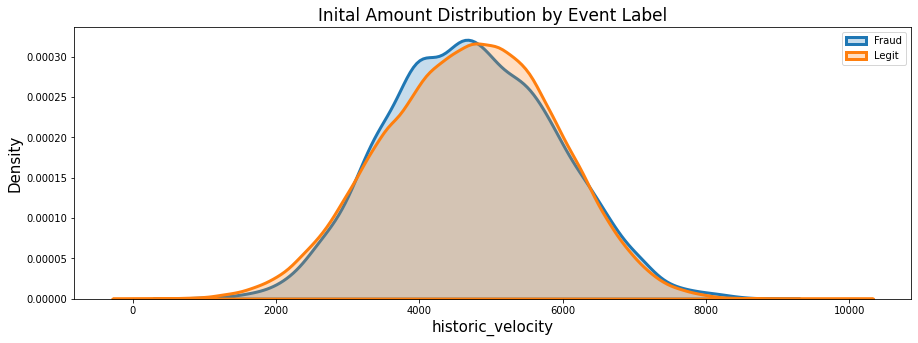

In [26]:
# To see transaction amount distribution for Historic Velocity column:
distplot_viz(
    data=df_data,
    column="historic_velocity",
    separate_column="EVENT_LABEL",
    condition_1="fraud",
    condition_2="legit",
    label1="Fraud",
    label2="Legit",
    title="Inital Amount Distribution by Event Label",
    color1="blue",
    color2="red",
)

In [27]:
list_of_column_descriptive = ["historic_velocity"]
print("Fraud transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "fraud"], list_of_column_descriptive
)
print("Legit transactions; \n")
df_descriptive_statistics(
    df_data[df_data["EVENT_LABEL"] == "legit"], list_of_column_descriptive
)

Fraud transactions; 

       historic_velocity
count        8161.000000
mean         4722.540130
std          1168.436752
min           862.000000
25%          3884.000000
50%          4692.000000
75%          5550.000000
max          8732.000000

Mode: 
    historic_velocity
0             4761.0
1             4996.0

Legit transactions; 

       historic_velocity
count      141724.000000
mean         4701.028774
std          1189.613868
min            50.000000
25%          3871.000000
50%          4732.000000
75%          5548.000000
max          9999.000000

Mode: 
    historic_velocity
0             5070.0



#### Findings:  
* Fraudelent transaction's minimum value is 17 times bigger than legit transactions. 
* Distributions are approximately similar. 
* These information shows that fraudelent people most focuses on bigger historic velocity. Without the business knowledge hard to evaluate further. 

### Bivariate Relationships: Categorical Variables
### Billing States & Event Label

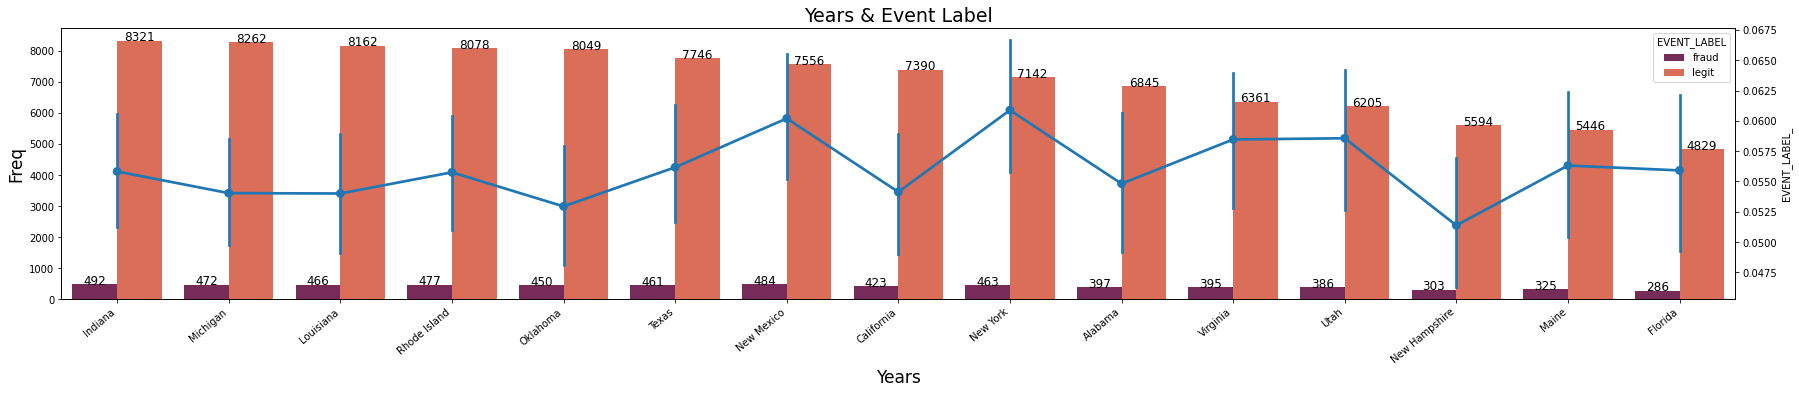

In [30]:
filter_list = ["fraud", "legit"]
countplot_pointplot_viz_top15(
    df_data,
    filter_list,
    "billing_state",
    "EVENT_LABEL",
    "EVENT_LABEL_",
    "Years",
    "Freq",
    "Years & Event Label",
    palette="rocket",
    figsize_x=30,
    figsize_y=5,
)

In [ ]:
countplot_viz(
    df_data,
    "billing_state",
    "Billing State",
    "Count",
    "Event Label Counts by Billing States",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* Fraudelent transactions mostly appeare at Indiana and New Mexico. 

### Currency & Event Label

In [ ]:
countplot_viz(
    df_data,
    "currency",
    "currency",
    "Count",
    "Event Label Counts by Transaction Types",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

In [ ]:
print(
    "Fraud rate into cad currency:\n--------------------------\n",
    5787 / (107964 + 5787),
)
print(
    "Fraud rate into usd currency:\n--------------------------\n",
    1920 / (29848 + 1920),
)
print(
    "Fraud rate into euro currency:\n--------------------------\n",
    450 / (3923 + 450),
)

#### Findings:
* If we looking the count of fraudelent activities, Biggest count is belong to cad currency. 
* If we looking the rate of fraudelent activities, Biggest rate is belong to euro currency. It shows shopping with euro currency is open to fraud. 

### Transaction Types & Event Label: 

In [ ]:
countplot_viz(
    df_data,
    "transaction_type",
    "Transaction Type",
    "Count",
    "Event Label Counts by Transaction Types",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* Fraudelent transactions mostly appeare at U, F and I. 

### Transaction Env & Event Label: 

In [ ]:
countplot_viz(
    df_data,
    "transaction_env",
    "Transaction Env",
    "Count",
    "Event Label Counts by Transaction Env",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* Fraudelent transactions mostly appeare at G, I and D. 

### Transaction Initiate & Event Label: 

In [ ]:
countplot_viz(
    df_data,
    "tranaction_initiate",
    "Transaction Initiate",
    "Count",
    "Event Label Counts by Transaction Initiate",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

#### Findings: 
* Fraudelent transactions mostly appeare at G, I and D. 

### Card Bin & Event Label:

In [ ]:
countplot_viz(
    df_data,
    "card_bin",
    "Card Bin",
    "Count",
    "Event Label Counts by Card Bin",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

####  Findings:

### Email Domain & Event Label:  

In [ ]:
countplot_viz(
    df_data,
    "email_domain",
    "email_domain",
    "Count",
    "Event Label Counts by Transaction Initiate",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

### CVV & Event Label:  

In [ ]:
countplot_viz(
    df_data,
    "cvv",
    "email_domain",
    "Count",
    "Event Label counts by CVV",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)

### Signature Image & Event Label:  

In [ ]:
countplot_viz(
    df_data,
    "signature_image",
    "email_domain",
    "Count",
    "Event Label counts by CVV",
    hue="EVENT_LABEL",
    rotation=45,
    figsize_x=25,
    figsize_y=5,
)